# MVP Notebook Daniel

In [107]:
import preprocessing
import wrangle
import model

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score


# ignore warnings
import warnings
warnings.simplefilter(action='ignore')

In [108]:
df = preprocessing.get_model_df()

In [109]:
df = preprocessing.add_new_features(df)

In [110]:
def filter_top_cities(df):

    df["city_state"] = df["city"] + "_" + df["state"]

    city_mask = df.groupby("city_state").year.count()

    city_mask = city_mask[city_mask == 15]

    # apply city mask to shrink the df
    def in_city_mask(x):
        return x in city_mask
    df = df[df.city_state.apply(in_city_mask)]

    df = df.sort_values(["city", "state", "year"])
    
    return df

In [111]:
df = filter_top_cities(df)

## <span style='background :yellow' > Adding the labeling </span>

In [112]:
# # Using the Evolution Index as a label:
# # For values that are higher than 100% in evolution index.

# df["ei_label"] = np.where(df.ei > 1, 1, 0)

In [113]:
# using future data to create the labels

def labeling_future_data(df):
    """this function takes in a data frame and returns a boolean column that identifies
    if a city_state_year is a market that should be entered"""
    df["label_quantity_of_mortgages_pop_2y"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["quantity_of_mortgages_pop"]]
                                  .pct_change(2)
                                  .shift(-2))
    df["label_total_mortgage_volume_pop_2y"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["total_mortgage_volume_pop"]]
                                  .pct_change(2)
                                  .shift(-2))
    Q3 = df.label_quantity_of_mortgages_pop_2y.quantile(.75)
    Q1 = df.label_quantity_of_mortgages_pop_2y.quantile(.25)
    upper_fence_quantity = Q3 + ((Q3-Q1)*1.5)
    upper_fence_quantity
    Q3 = df.label_total_mortgage_volume_pop_2y.quantile(.75)
    Q1 = df.label_total_mortgage_volume_pop_2y.quantile(.25)
    upper_fence_volume = Q3 + ((Q3-Q1)*1.5)
    upper_fence_volume
    df['should_enter'] = (df.label_total_mortgage_volume_pop_2y > upper_fence_volume) | (df.label_quantity_of_mortgages_pop_2y > upper_fence_quantity)
    return df

In [114]:
df = labeling_future_data(df)

In [115]:
df.should_enter.value_counts()

False    338
True      52
Name: should_enter, dtype: int64

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 1513 to 156
Data columns (total 23 columns):
city                                  390 non-null object
state                                 390 non-null object
year                                  390 non-null int64
quantity_of_mortgages_pop             390 non-null int64
total_mortgage_volume_pop             390 non-null int64
average_mortgage_volume_pop           390 non-null float64
median_mortgage_amount_pop            390 non-null float64
quantity_of_mortgages_nc              180 non-null float64
total_mortgage_volume_nc              180 non-null float64
average_mortgage_volume_nc            180 non-null float64
median_mortgage_amount_nc             180 non-null float64
label                                 390 non-null bool
city_state_vol_delta_pop              364 non-null float64
city_state_vol_delta_nc               310 non-null float64
city_state_qty_delta_pop              364 non-null float64
city_state_qty_del

In [117]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

In [118]:
def train_test_data(df):
    train, test = train_test_split(df, train_size=.75, random_state=123, stratify = df["should_enter"])
    return train, test

#__Main Pre-modeling function__#
def prep_data_for_modeling(df, features_for_modeling, label_feature):

    # To avoid Nan's, I have removed all data from 2006 (because all the var's would be nan)
    df_model = df[df.year > 2007]

    # Create an observation id to reduce the chance of mistake's
    df_model["observation_id"] = df_model.city + "_" + df_model.state + "_"  + df_model.year.astype(str)

    # select that features that we want to model, and use our observation id as the row id
    features_for_modeling += ["observation_id"]
    features_for_modeling += [label_feature]
    data = df_model[features_for_modeling].set_index("observation_id")

    train, test = train_test_data(data)
    train = train.sort_values("observation_id")
    test = test.sort_values("observation_id")

    X_train = train.drop(columns=label_feature)
    y_train = train[label_feature]
    X_test = test.drop(columns=label_feature)
    y_test = test[label_feature]

    return X_train, y_train, X_test, y_test

In [119]:
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
label_feature = "should_enter"
X_train, y_train, X_test, y_test = prep_data_for_modeling(df, features_for_modeling, label_feature)

In [120]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values(scaler, train, test):
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return scaler, train_scaled, test_scaled

# Linear scaler
def min_max_scaler(train, test):
    scaler = MinMaxScaler().fit(train)
    scaler, train_scaled, test_scaled = return_values(scaler, train , test)
    return scaler, train_scaled, test_scaled

In [121]:
# Scaler is ready - in case we need it

scaler, train_scaled, test_scaled = min_max_scaler(X_train, X_test)

In [122]:
assert(train_scaled.shape[1] == test_scaled.shape[1])

In [123]:
train_scaled.head()

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop
Atlanta_GA_2008,0.021739,0.010172,0.008122,0.033455
Atlanta_GA_2010,0.217391,0.087637,0.022332,0.056728
Atlanta_GA_2011,0.195652,0.063380,0.025009,0.045856
Atlanta_GA_2012,0.239130,0.085915,0.026302,0.031960
Atlanta_GA_2014,0.217391,0.037806,0.039231,0.053211


In [124]:
train_scaled.isnull().sum()

quantity_of_mortgages_pop     0
city_state_qty_delta_pop      0
ei                            0
median_mortgage_amount_pop    0
dtype: int64

In [125]:
grid, df_result, best_model = model.run_decision_tree(train_scaled, y_train)

{'criterion': 'entropy', 'max_depth': 10, 'score': 0.2333333333333333}


In [47]:
grid, df_result, best_model = model.run_random_forest(train_scaled, y_train)

{'max_depth': 9, 'min_samples_leaf': 1, 'score': 0.1}


In [126]:
grid, df_result, best_model = model.run_knn(train_scaled, y_train)

{'n_neighbors': 1, 'weights': 'uniform', 'score': 0.175}


----

# Evaluation

In [127]:
grid, df_result, best_model = model.run_decision_tree(train_scaled, y_train)

{'criterion': 'entropy', 'max_depth': 9, 'score': 0.25}


In [128]:
y_pred = best_model.predict(train_scaled)

In [129]:
labels = sorted(y_train.unique())
matrix = pd.DataFrame(confusion_matrix(y_train, y_pred), index = labels, columns = labels)

In [131]:
recall_score(y_train, y_pred)

0.8461538461538461

In [132]:
print(matrix)

       False  True 
False    214      0
True       6     33


In [133]:
best_model.score(test_scaled, y_test)

0.7411764705882353

In [134]:
y_pred = best_model.predict(test_scaled)

In [135]:
labels = sorted(y_train.unique())
matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = labels, columns = labels)

In [136]:
recall_score(y_test, y_pred)

0.23076923076923078

In [137]:
print(matrix)

       False  True 
False     60     12
True      10      3


----

# Prediction

In [60]:
model_df = preprocessing.get_model_df()

df["city_state"] = df["city"] + "_" + df["state"]

city_mask = df.groupby("city_state").year.count()

city_mask = city_mask[city_mask == 15]

# apply city mask to shrink the df
def in_city_mask(x):
    return x in city_mask
df = df[df.city_state.apply(in_city_mask)]

df = preprocessing.add_new_features(df)

df = df.sort_values(["city", "state", "year"])

In [61]:
df.head()

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,...,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,label_quantity_of_mortgages_pop_2y,label_total_mortgage_volume_pop_2y,should_enter
1513,Atlanta,GA,2006,6,33186800,5.531133e+06,4457100.0,2.0,9181100.0,4590550.0,...,NaN,NaN,NaN,985749936,NaN,NaN,Atlanta_GA,NaN,NaN,False
1815,Atlanta,GA,2007,9,29105800,3.233978e+06,2990200.0,2.0,4541700.0,2270850.0,...,-0.505321,0.500000,0.0,952578100,-0.033651,0.907570,Atlanta_GA,NaN,NaN,False
7673,Atlanta,GA,2008,2,6735000,3.367500e+06,3367500.0,1.0,4950000.0,4950000.0,...,0.089900,-0.777778,-0.5,432971200,-0.545474,0.509096,Atlanta_GA,0.0,-0.812906,False
773,Atlanta,GA,2009,9,49972900,5.552544e+06,4400000.0,1.0,3750000.0,3750000.0,...,-0.242424,3.500000,0.0,1116634600,1.579004,2.877033,Atlanta_GA,4.5,9.213569,True
469,Atlanta,GA,2010,11,68788385,6.253490e+06,5196100.0,2.0,7203500.0,3601750.0,...,0.920933,0.222222,1.0,2568950085,1.300618,0.598323,Atlanta_GA,4.5,14.076042,True


In [67]:
features_for_predicting = ["ei"]

In [68]:
predictions = df[(df.year == 2020) | (df.year == 2019)].groupby("city_state")[features_for_predicting].mean()
predictions

,ei
city_state,
Atlanta_GA,0.854755
Austin_TX,1.443730
Baltimore_MD,0.829841
Boston_MA,1.139998
Chicago_IL,1.028100
Cincinnati_OH,2.437869
Cleveland_OH,1.131003
Dallas_TX,1.296162
Detroit_MI,5.962691


In [69]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values_prediction(scaler, df):
    train_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns.values).set_index([df.index.values])
    return scaler, train_scaled

# Linear scaler
def min_max_scaler_prediction(df):
    scaler = MinMaxScaler().fit(df)
    scaler, df_scaled = return_values_prediction(scaler, df)
    return scaler, df_scaled

In [70]:
scaler, predictions_scaled = min_max_scaler_prediction(predictions)

In [71]:
predictions["label"] = best_model.predict(predictions_scaled)

In [72]:
predictions

,ei,label
city_state,,
Atlanta_GA,0.854755,False
Austin_TX,1.443730,False
Baltimore_MD,0.829841,False
Boston_MA,1.139998,True
Chicago_IL,1.028100,False
Cincinnati_OH,2.437869,True
Cleveland_OH,1.131003,True
Dallas_TX,1.296162,False
Detroit_MI,5.962691,False


In [73]:
city = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[0]

state = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[1]

In [74]:
predictions = predictions.reset_index()

In [75]:
predictions["city"] = city

predictions["state"] = state

In [76]:
predictions

,city_state,ei,label,city,state
0,Atlanta_GA,0.854755,False,Atlanta,GA
1,Austin_TX,1.443730,False,Austin,TX
2,Baltimore_MD,0.829841,False,Baltimore,MD
3,Boston_MA,1.139998,True,Boston,MA
4,Chicago_IL,1.028100,False,Chicago,IL
5,Cincinnati_OH,2.437869,True,Cincinnati,OH
6,Cleveland_OH,1.131003,True,Cleveland,OH
7,Dallas_TX,1.296162,False,Dallas,TX
8,Detroit_MI,5.962691,False,Detroit,MI
9,Houston_TX,0.547147,False,Houston,TX


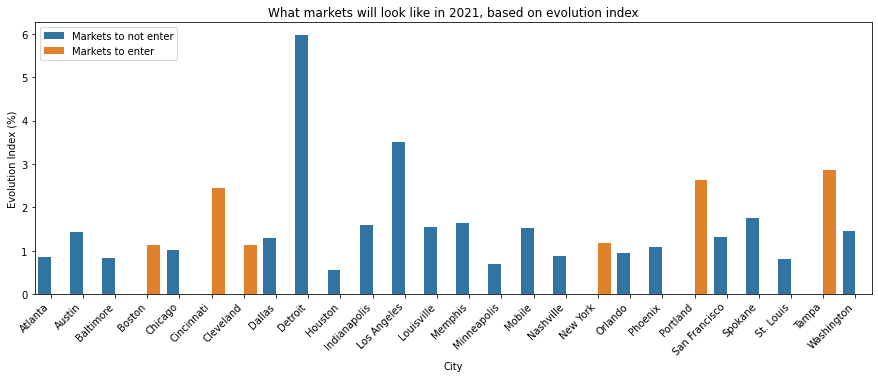

In [77]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=predictions, x="city", y="ei", hue="label")
plt.title("What markets will look like in 2021, based on evolution index")
plt.xticks(rotation=45, ha="right")
plt.xlabel("City")
plt.ylabel("Evolution Index (%)")
new_labels = ['Markets to not enter', 'Markets to enter']
h, l = ax.get_legend_handles_labels()
ax.legend(h, new_labels)
plt.show()